In [ ]:
import pandas as pd

# Assuming you have the necessary CSV files already loaded into your environment.

# Combine the data from all files (as done earlier)
files = [
    "Hari 17-06-2024.csv",
    "Hari 19-06-2024.csv",
    "Hari 25-06-2024.csv",
    "Hari 26-06-2024.csv",
    "Hari 28-06-2024.csv"
]

# Load each file into a DataFrame
dataframes = []
for file in files:
    df = pd.read_csv(file, header=None)
    dataframes.append(df)

# Define column names
column_names = ["Timestamp", "IP Address", "Reactor", "Output Type", "Current Output"]

# Clean and filter the dataframes
filtered_dfs = []
for df in dataframes:
    df.columns = column_names
    filtered_df = df[df["Output Type"] == "IOUT"]
    filtered_dfs.append(filtered_df)

# Combine all filtered dataframes into one
combined_df = pd.concat(filtered_dfs)

# Convert the Current Output to amperes (mA to A)
combined_df["Current Output"] = pd.to_numeric(combined_df["Current Output"], errors='coerce') / 1000

# Convert the LabVIEW timestamps to datetime format (from 01/01/1904 epoch)
labview_epoch = pd.Timestamp("1904-01-01 00:00:00")
combined_df["Timestamp"] = pd.to_timedelta(combined_df["Timestamp"].astype(float), unit='s') + labview_epoch

# Save the combined DataFrame to a CSV file
combined_df.to_csv("combined_df_sugar_solution.csv", index=False)


<ipython-input-4-0e56a9c7cabe>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 6).colors


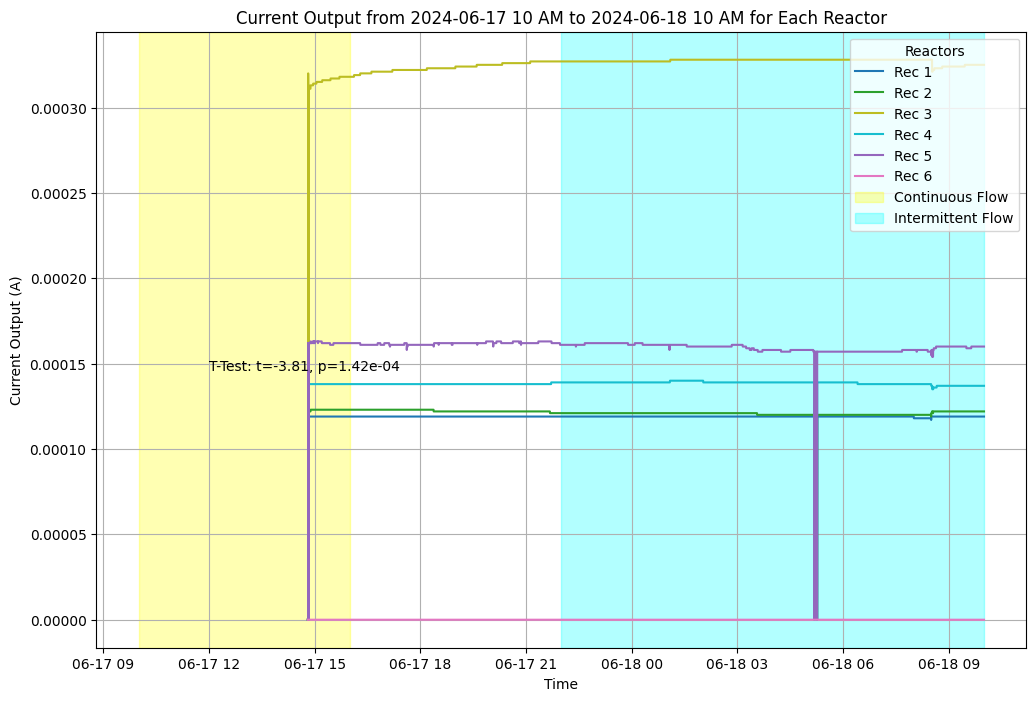

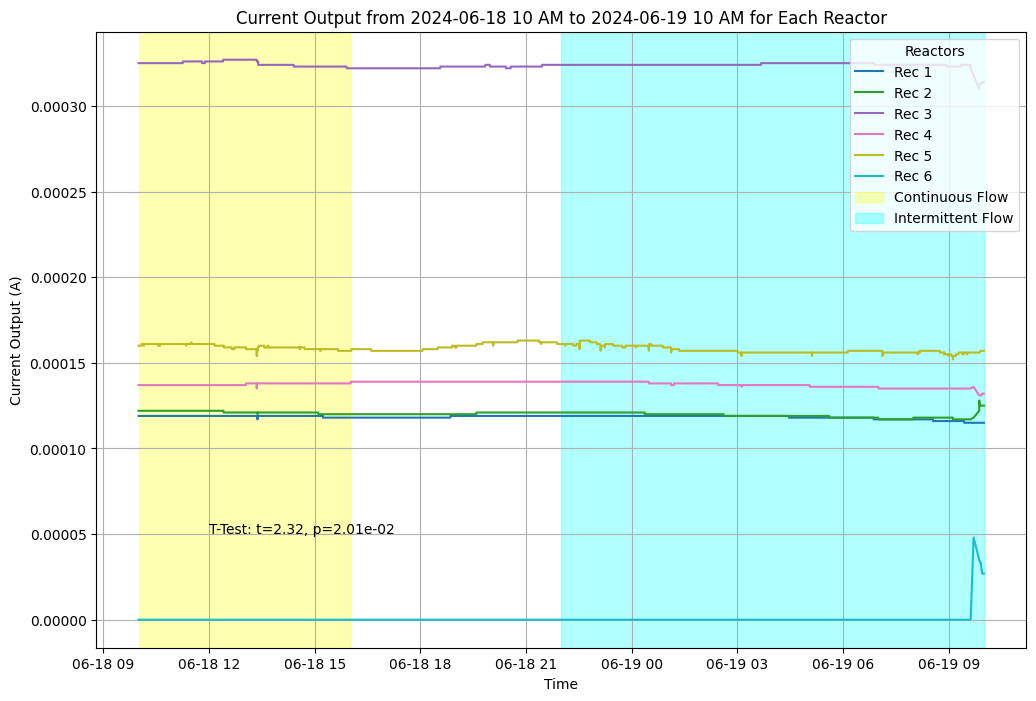

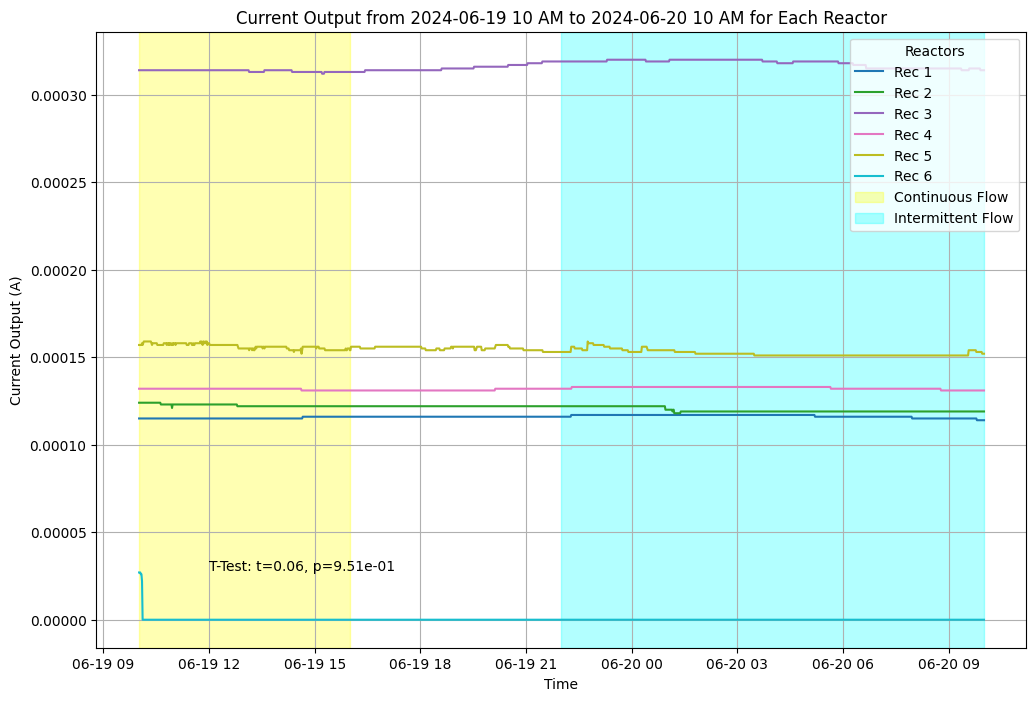

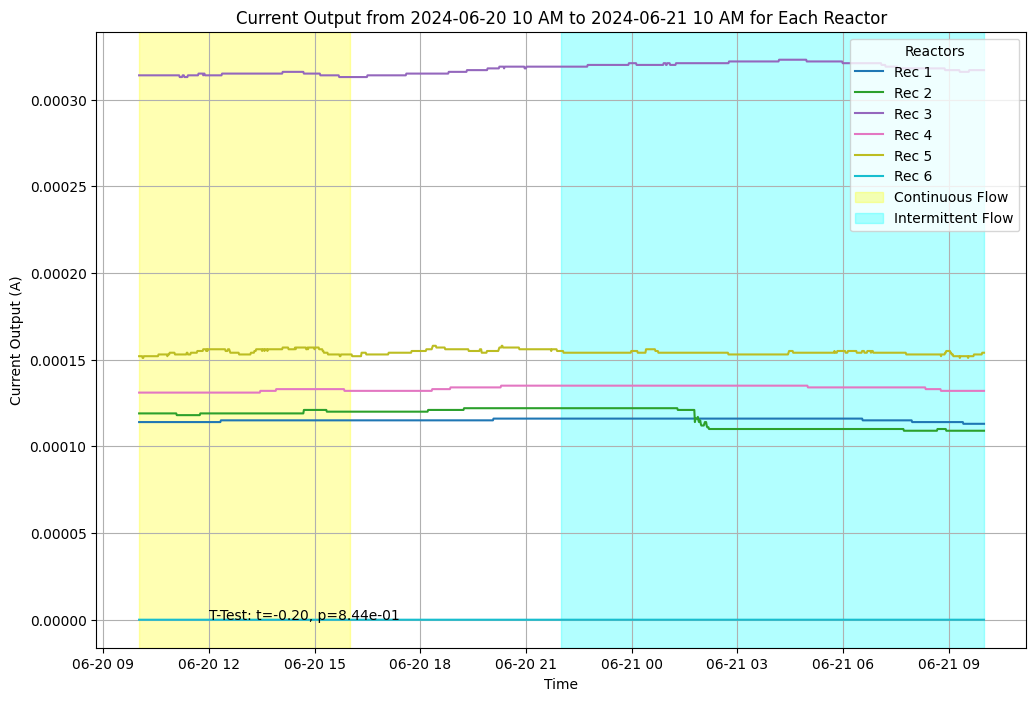

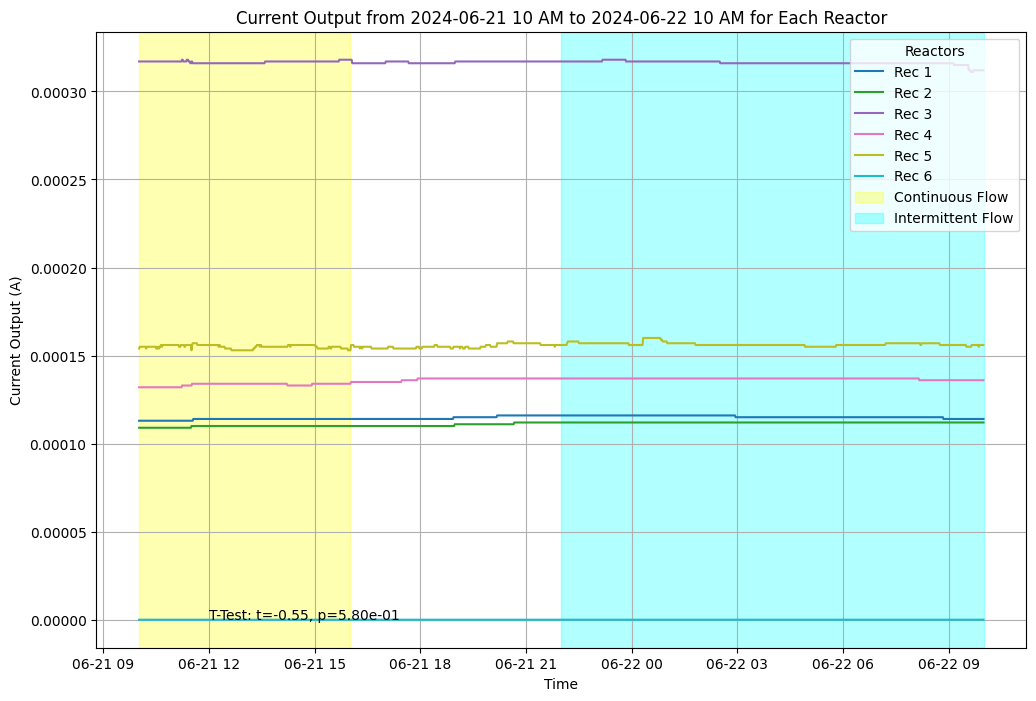

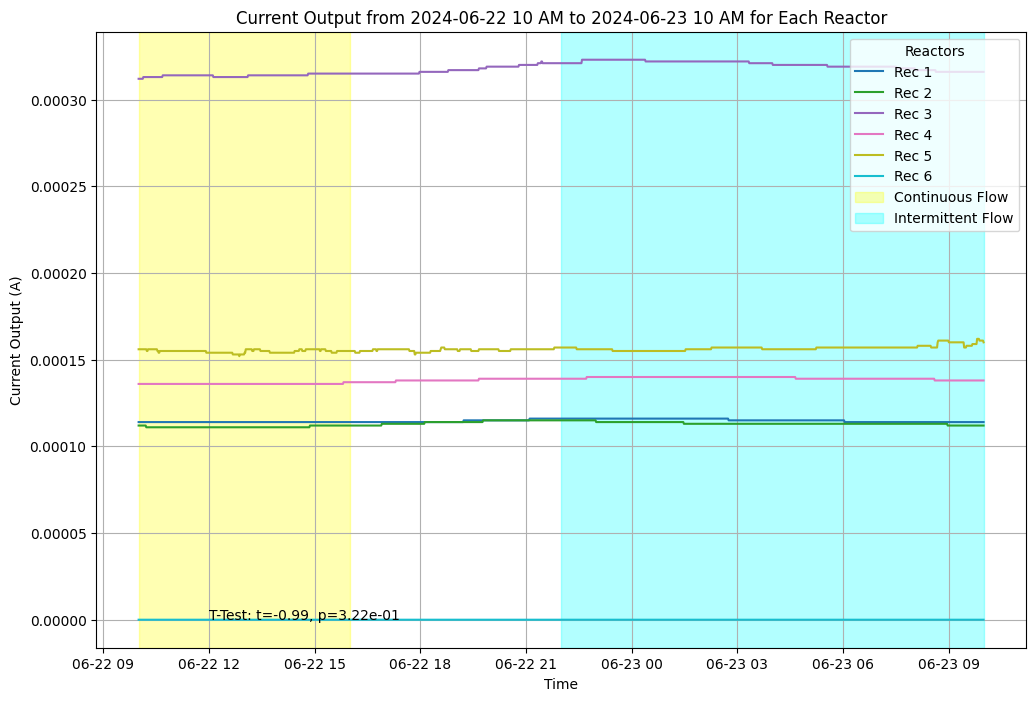

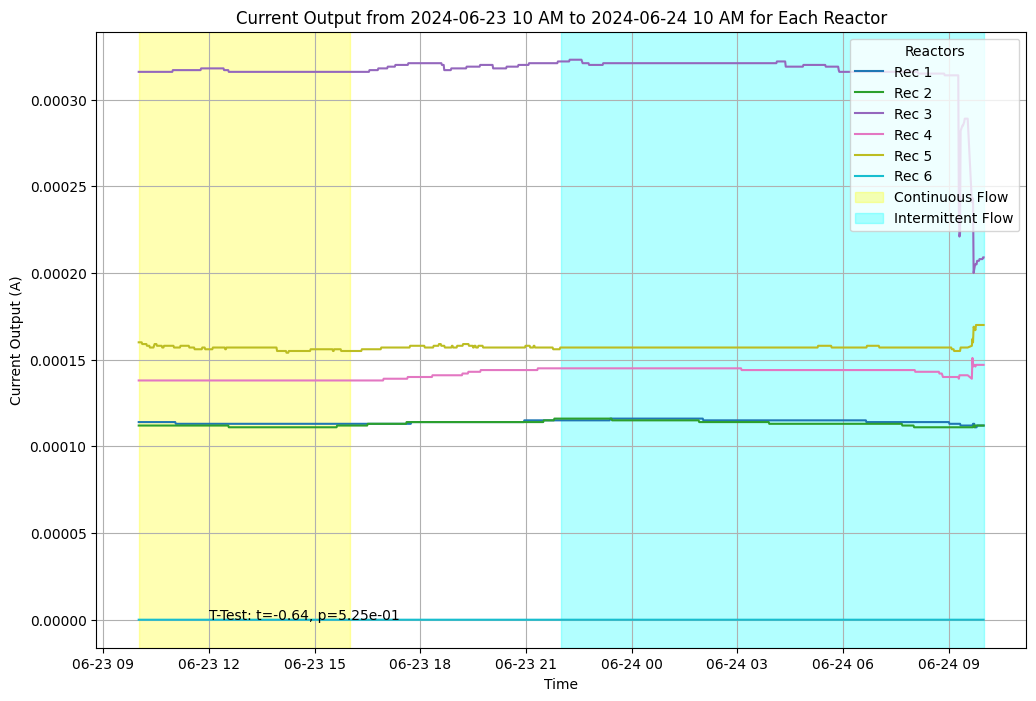

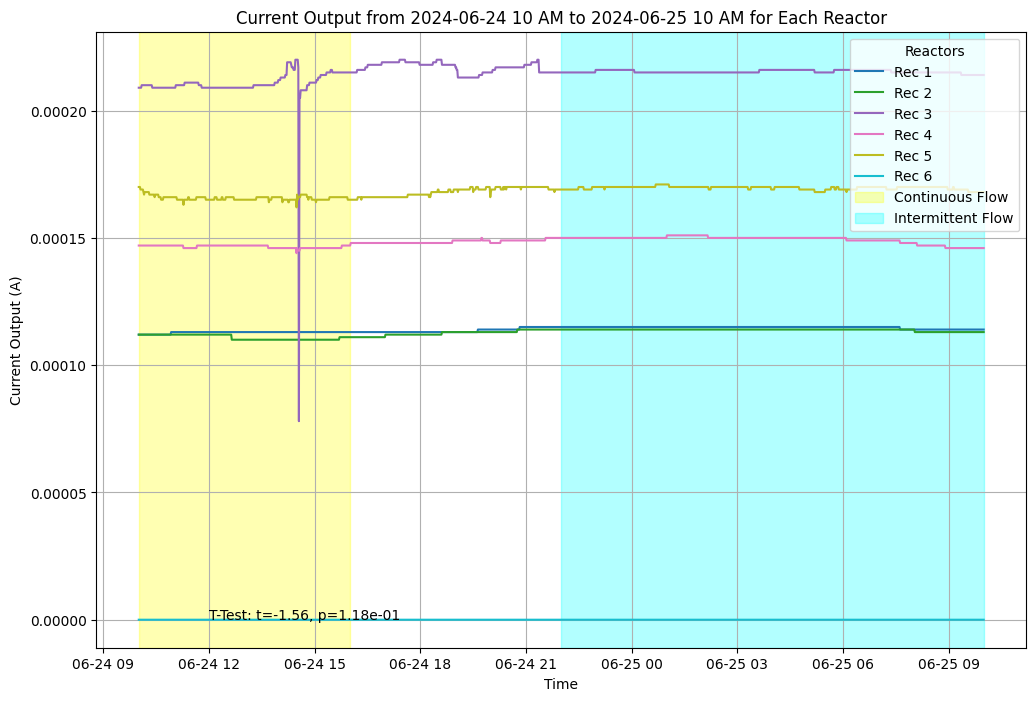

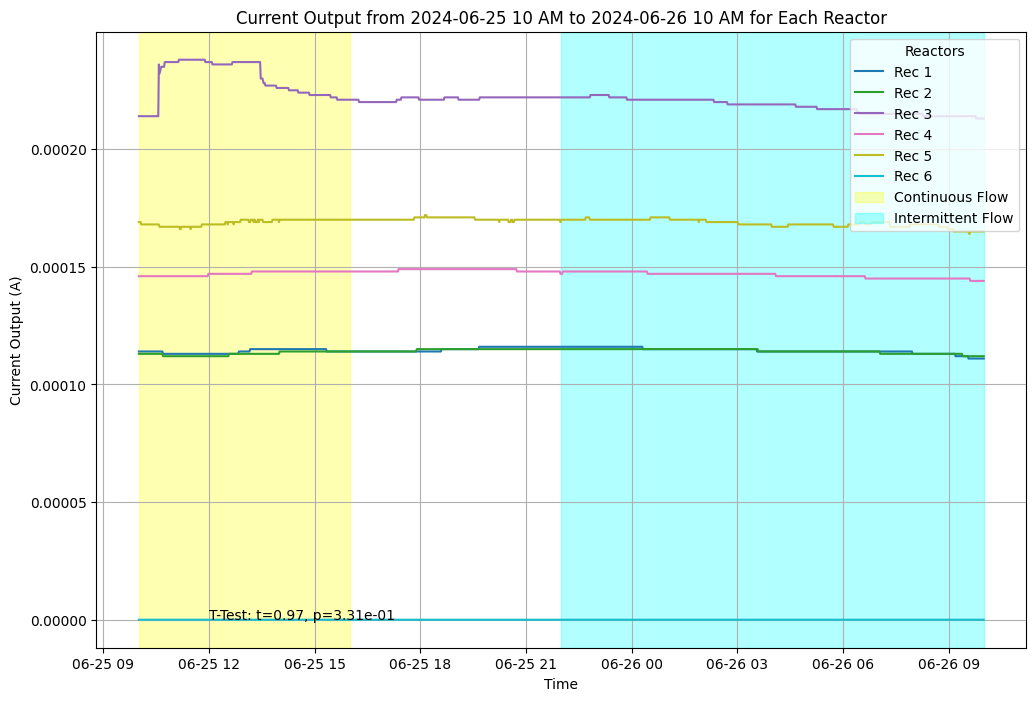

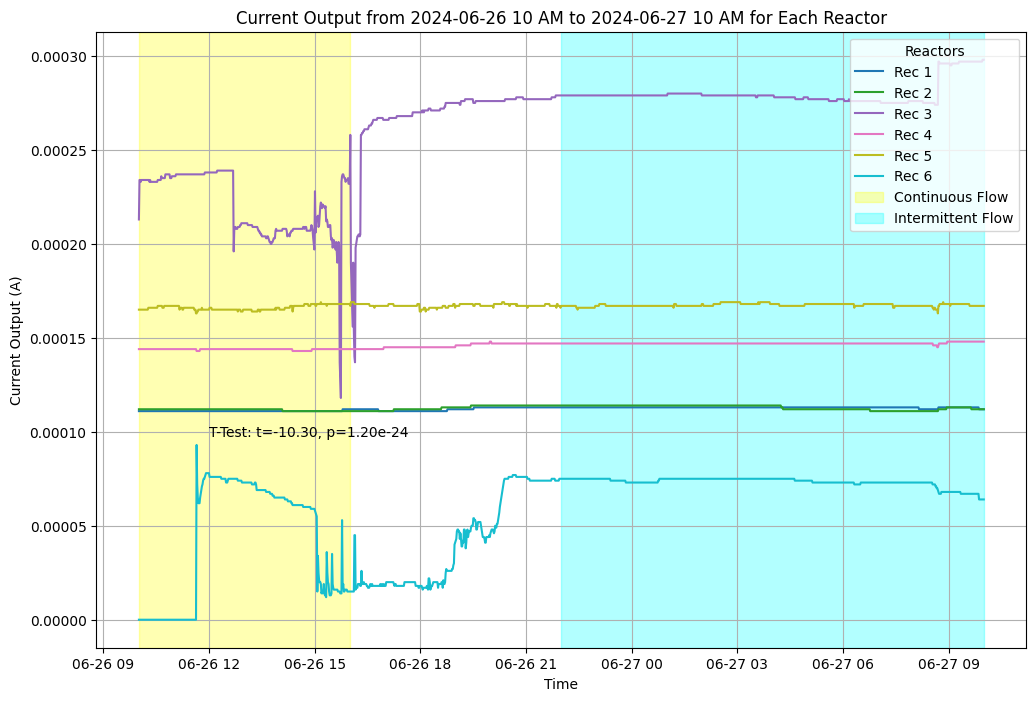

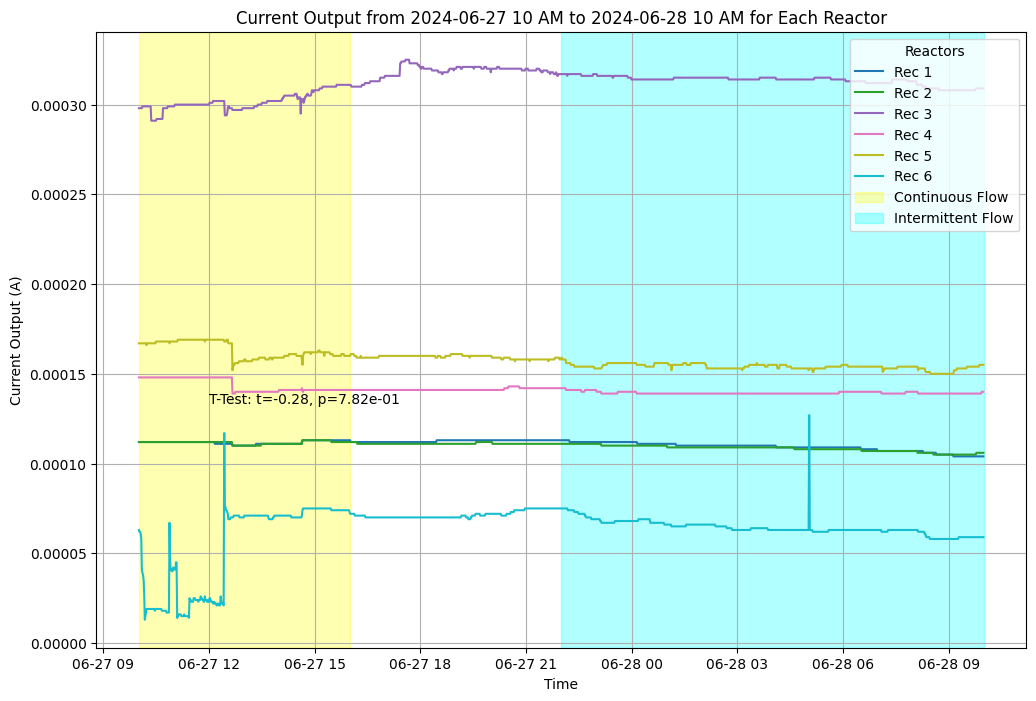

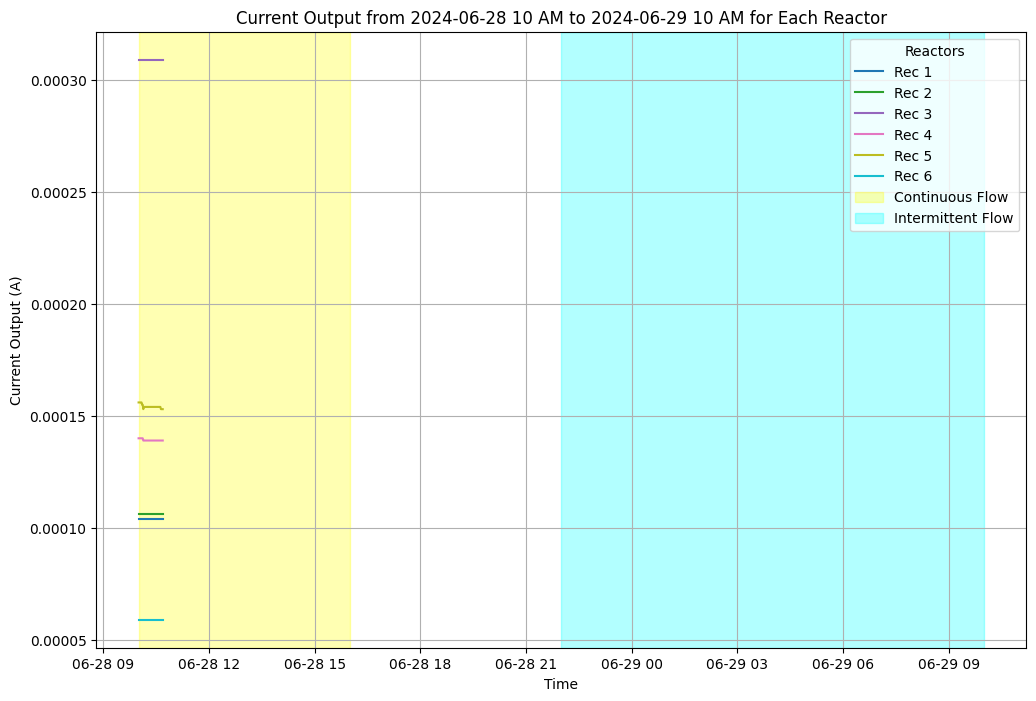

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy import stats

# Ensure 'Timestamp' is in datetime format
combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'], errors='coerce')

# Create a custom 'Period' column that groups from 10 AM of the current day to 10 AM of the next day
combined_df['Period'] = combined_df['Timestamp'].apply(lambda x: (x - pd.DateOffset(hours=10)).date())

# Define a list of distinct colors for the reactors
colors = cm.get_cmap('tab10', 6).colors

# Reactor labels without IP addresses
simple_labels = {
    ("192.168.1.198", 1): "Rec 1",
    ("192.168.1.198", 2): "Rec 2",
    ("192.168.1.200", 1): "Rec 3",
    ("192.168.1.200", 2): "Rec 4",
    ("192.168.1.201", 1): "Rec 5",
    ("192.168.1.201", 2): "Rec 6",
}

# Time periods for continuous and intermittent flows
continuous_flow_time = ('10:00', '16:00')  # 10am to 4pm
intermittent_flow_time = ('22:00', '10:00')  # 10pm to 10am next day

# Function to filter data by time range (for 24-hour periods that span across days)
def filter_by_time(group, start_time, end_time):
    start = pd.to_datetime(start_time).time()
    end = pd.to_datetime(end_time).time()

    if start < end:
        # If the start time is before the end time (same day)
        return group[(group['Timestamp'].dt.time >= start) & (group['Timestamp'].dt.time <= end)]
    else:
        # If the start time is after the end time (spans across two days)
        return group[(group['Timestamp'].dt.time >= start) | (group['Timestamp'].dt.time <= end)]

# Loop over each period (from 10 AM one day to 10 AM the next day) and plot the data
for period, group in combined_df.groupby('Period'):
    plt.figure(figsize=(12, 8))

    # Track which reactors have already been plotted to prevent duplicates
    plotted_reactors = set()

    # Data for T-Test
    continuous_flow_data = []
    intermittent_flow_data = []

    # Plotting for each reactor based on 'IP Address' and 'Reactor' combination for the specific period
    for i, ((ip, reactor), sub_group) in enumerate(group.groupby(['IP Address', 'Reactor'])):
        label = simple_labels.get((ip, reactor), f"Rec {reactor}")
        if label not in plotted_reactors:
            plt.plot(sub_group['Timestamp'], sub_group['Current Output'], label=label, color=colors[i % 6])
            plotted_reactors.add(label)

        # Filter and collect data for continuous and intermittent flows
        continuous_data = filter_by_time(sub_group, f"{period} 10:00", f"{period} 16:00")['Current Output']
        intermittent_data = filter_by_time(sub_group, f"{period} 22:00", f"{period + pd.DateOffset(days=1)} 10:00")['Current Output']

        # Append to the lists for T-Test
        continuous_flow_data.extend(continuous_data)
        intermittent_flow_data.extend(intermittent_data)

    # Perform T-Test
    if continuous_flow_data and intermittent_flow_data:  # Check if there's data for both periods
        t_stat, p_value = stats.ttest_ind(continuous_flow_data, intermittent_flow_data, equal_var=False)
    else:
        t_stat, p_value = None, None  # No sufficient data for T-test

    # Highlight continuous flow (10am to 4pm) and intermittent flow (10pm to 10am next day)
    plt.axvspan(pd.Timestamp(f"{period} 10:00"), pd.Timestamp(f"{period} 16:00"), color='yellow', alpha=0.3, label='Continuous Flow')
    plt.axvspan(pd.Timestamp(f"{period} 22:00"), pd.Timestamp(f"{period + pd.DateOffset(days=1)} 10:00"), color='cyan', alpha=0.3, label='Intermittent Flow')

    # Adding titles and labels
    plt.xlabel("Time")
    plt.ylabel("Current Output (A)")
    # plt.title(f"Current Output from {period} 10 AM to {period + pd.DateOffset(days=1).strftime('%Y-%m-%d')} 10 AM for Each Reactor")
    plt.title(f"Current Output from {period} 10 AM to {(period + pd.DateOffset(days=1)).strftime('%Y-%m-%d')} 10 AM for Each Reactor")


    # Add T-test value to the plot if calculated
    if t_stat is not None:
        plt.text(pd.Timestamp(f"{period} 12:00"), max(sub_group['Current Output']) * 1.05,
                 f"T-Test: t={t_stat:.2f}, p={p_value:.2e}", fontsize=10, color='black')

    plt.legend(title="Reactors", loc="upper right")
    plt.grid(True)

    # Save each plot with a filename that includes the period
    plt.savefig(f"Current_Output_{period}_to_{period + pd.DateOffset(days=1)}_with_flows.png")

    # Show the plot
    plt.show()